In [2]:
# ===============================
# Core Python Libraries
# ===============================
import os
import pickle
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from scipy.special import expit  # sigmoid

# ===============================
# Data Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ===============================
# NLP: NLTK & Gensim
# ===============================
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.util import ngrams

# ===============================
# Scikit-learn: Preprocessing, Models, Metrics
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ===============================
# Transformers (Hugging Face)
# ===============================
from transformers import (
    AutoTokenizer, AutoModel,
    RobertaTokenizer, RobertaModel,
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification
)
import torch
from torch.optim import AdamW

# ===============================
# Custom Modules
# ===============================
from metrics_calculator import MetricsCalculator
from graphs import GraphPlotter
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
import nltk

# Tokenizer
nltk.download('punkt', quiet=True)

# Stopwords
nltk.download('stopwords', quiet=True)

# WordNet for lemmatizer
nltk.download('wordnet', quiet=True)

#  POS tagging for better lemmatization
nltk.download('averaged_perceptron_tagger', quiet=True)


In [3]:
def upload_dataset(file_path):
    """Load the dataset from a CSV file"""
    df = pd.read_csv(file_path,)
    return df

In [4]:
path=r"Dataset/A16 Multiple Langugesdataset.csv"

In [5]:
df= upload_dataset(path)
df

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [6]:
def preprocess_data(df, save_path=None, target_cols=None):

    global label_encoders
    label_encoders = {}  # dictionary to hold encoders for each target column

    if save_path and os.path.exists(save_path):
        print(f"Loading existing preprocessed file: {save_path}")
        df = pd.read_csv(save_path)
    else:
        print("Preprocessing data" + (f" and saving to: {save_path}" if save_path else " (no saving)"))
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        def clean_text(text):
            text = str(text).lower()
            tokens = word_tokenize(text)
            tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum() and t not in stop_words]
            return ' '.join(tokens)

        # Separate target columns
        target_df = None
        if target_cols:
            existing_targets = [col for col in target_cols if col in df.columns]
            target_df = df[existing_targets].copy()
            df = df.drop(columns=existing_targets)

        # Process text columns
        text_columns = df.select_dtypes(include='object').columns
        for col in text_columns:
            df[f'processed_{col}'] = df[col].apply(clean_text)

        # Drop original text columns
        df.drop(columns=text_columns, inplace=True)

        # Reattach target columns
        if target_df is not None:
            for col in target_df.columns:
                df[col] = target_df[col]

        # Save only if path is specified
        if save_path:
            df.to_csv(save_path, index=False)

    # Select processed and numerical columns
    processed_text_cols = [col for col in df.columns if col.startswith('processed_')]
    non_text_cols = [col for col in df.columns if col not in processed_text_cols + (target_cols if target_cols else [])]

    # Join processed text columns into one string
    X_text = df[processed_text_cols].astype(str).agg(' '.join, axis=1)

    # Combine with numerical columns if any
    X_numeric = df[non_text_cols].values if non_text_cols else None
    if X_numeric is not None and len(X_numeric) > 0:
        X = [f"{text} {' '.join(map(str, numeric))}" for text, numeric in zip(X_text, X_numeric)]
    else:
        X = X_text.tolist()

    # Encode multiple target columns
    Y_dict = {}
    if target_cols:
        for col in target_cols:
            if col in df.columns:
                le = LabelEncoder()
                Y_dict[col] = le.fit_transform(df[col])
                label_encoders[col] = le

    return X, Y_dict

In [7]:
X, Y_dict = preprocess_data(df, save_path="model/cleaned_data.csv", target_cols=["language"])

Preprocessing data and saving to: model/cleaned_data.csv


In [8]:
labels_vars = {}  # dictionary to hold the labels
label_encoders_original=label_encoders
for i, (col, le) in enumerate(label_encoders.items(), start=1):
    var_name = f"labels{i}"
    labels_vars[var_name] = list(le.classes_)

# Now you can access them like:
labels1 = labels_vars.get("labels1")

print("labels1:", labels1)

metrics_calculator_lb1 = MetricsCalculator(labels1)

labels1: ['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'Hindi', 'Indonesian', 'Japanese', 'Korean', 'Latin', 'Persian', 'Portugese', 'Pushto', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai', 'Turkish', 'Urdu']


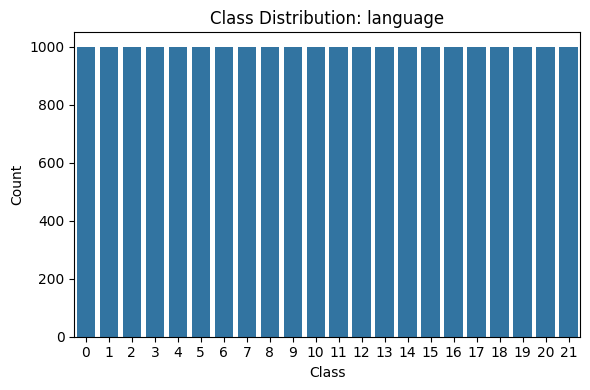

In [9]:
def plot_target_distributions(Y_dict):
    """
    Create count plots for each target column in Y_dict.
    
    Parameters:
        Y_dict (dict): Dictionary where keys are target column names and values are encoded label arrays.
    """
    # Convert to DataFrame for easy plotting
    y_df = pd.DataFrame(Y_dict)

    # Plot each column
    for col in y_df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=y_df[col])
        plt.title(f'Class Distribution: {col}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
plot_target_distributions(Y_dict)


In [10]:
def eda_nlp_analysis(X_text, num_words=100, top_n_words=20):
    """
    Perform NLP EDA:
        1. WordCloud
        2. Top N words
        3. Document length histogram
        4. POS tag frequency
        5. Bigram frequency

    Parameters:
        X_text (list of str): Input preprocessed text data.
        num_words (int): Number of words to show in word cloud.
        top_n_words (int): Number of top frequent words to plot.
    """
    print("Generating NLP EDA Visualizations...")

    # Flatten all tokens from all texts
    all_tokens = [word for doc in X_text for word in word_tokenize(doc)]

    # --- 1. WordCloud ---
    word_freq = Counter(all_tokens)
    wc = WordCloud(width=800, height=400, max_words=num_words, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {num_words} Words - WordCloud")
    plt.show()

    # --- 2. Top-N Frequent Words ---
    common_words = word_freq.most_common(top_n_words)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f"Top {top_n_words} Most Frequent Words")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

    # --- 3. Document Length Histogram ---
    doc_lengths = [len(word_tokenize(doc)) for doc in X_text]
    plt.figure(figsize=(10, 5))
    sns.histplot(doc_lengths, bins=20, kde=True, color='teal')
    plt.title("Distribution of Document Lengths (in words)")
    plt.xlabel("Number of Words per Document")
    plt.ylabel("Frequency")
    plt.show()

    # --- 4. POS Tag Frequency ---
    all_pos = [tag for _, tag in pos_tag(all_tokens)]
    pos_counts = Counter(all_pos).most_common()
    pos_tags, pos_freqs = zip(*pos_counts)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(pos_tags), y=list(pos_freqs), palette="coolwarm")
    plt.title("Part of Speech (POS) Tag Frequency")
    plt.xlabel("POS Tag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

    # --- 5. Bigram Frequency Plot ---
    bigrams = list(ngrams(all_tokens, 2))
    bigram_freq = Counter(bigrams).most_common(top_n_words)
    bigram_labels = [' '.join(b) for b, _ in bigram_freq]
    bigram_counts = [count for _, count in bigram_freq]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=bigram_counts, y=bigram_labels, palette="magma")
    plt.title(f"Top {top_n_words} Bigrams")
    plt.xlabel("Count")
    plt.ylabel("Bigram")
    plt.show()


Generating NLP EDA Visualizations...


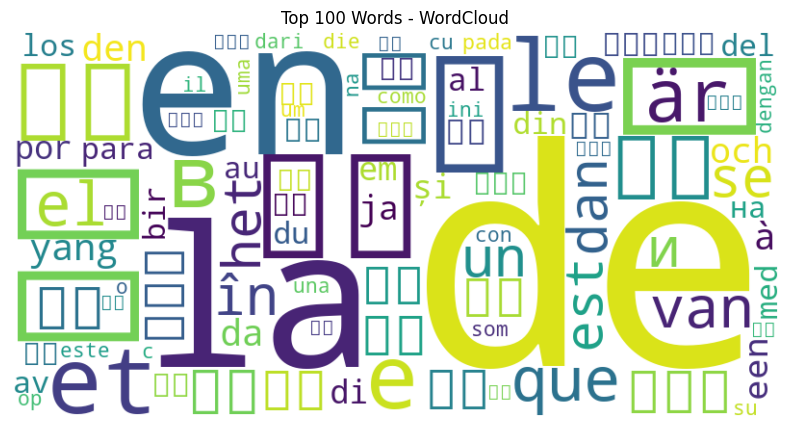

C:\Users\APPLE\AppData\Local\Temp\ipykernel_12544\1063056502.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


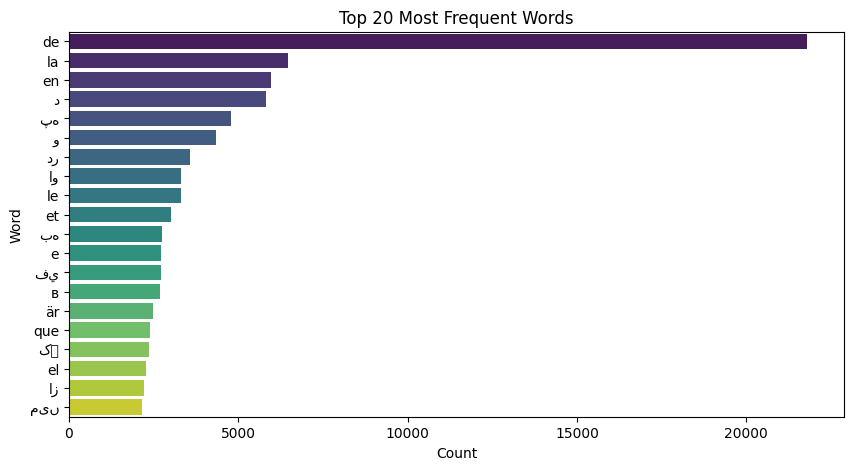

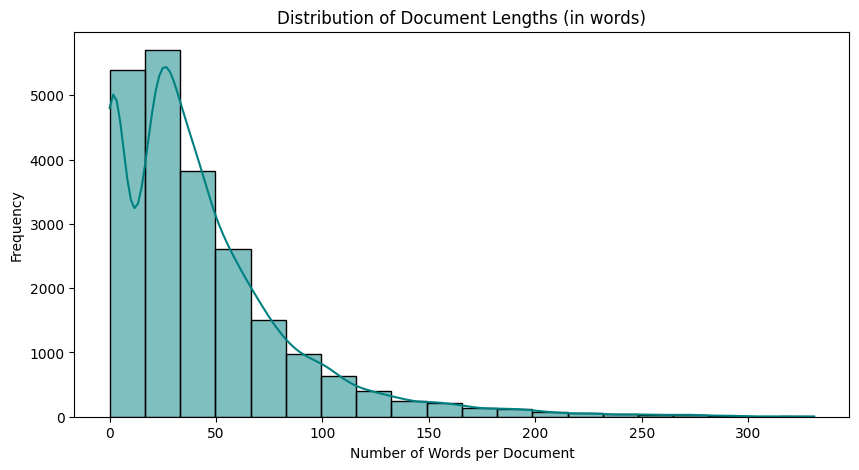

C:\Users\APPLE\AppData\Local\Temp\ipykernel_12544\1063056502.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_tags), y=list(pos_freqs), palette="coolwarm")


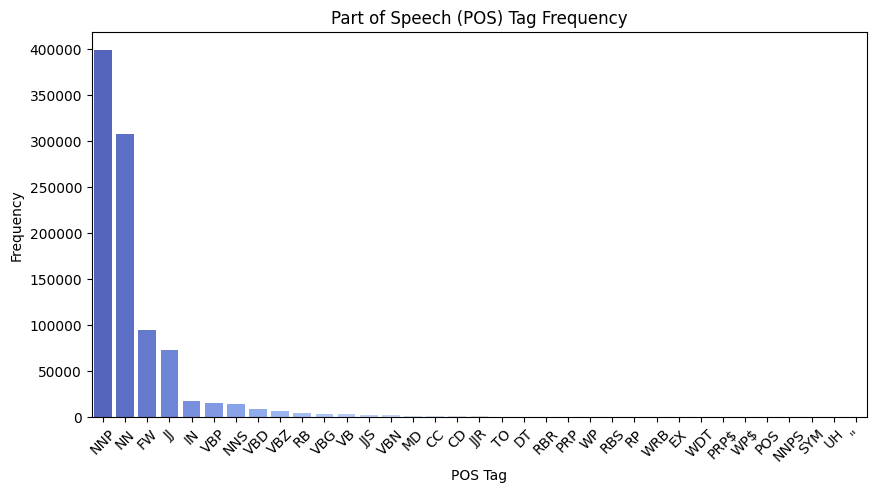

C:\Users\APPLE\AppData\Local\Temp\ipykernel_12544\1063056502.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette="magma")
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2324 (\N{DEVANAGARI LETTER AU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Envs\py3120env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 1729 (\N{ARABIC LETTER HE

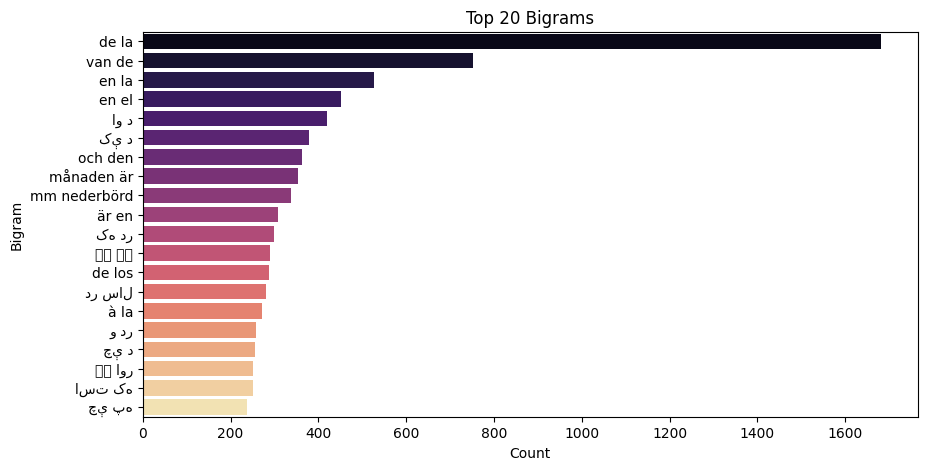

In [11]:
eda_nlp_analysis(X_text=X, num_words=100, top_n_words=20)

In [14]:
from tqdm import tqdm

def minilm_feature_extraction(texts, model_name='sentence-transformers/all-MiniLM-L6-v2', batch_size=32, pooling='mean'):
    """Extract MiniLM features from texts with tqdm progress bar."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting MiniLM embeddings"):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input)

        token_embeddings = model_output.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        attention_mask = encoded_input['attention_mask']
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        if pooling == 'mean':
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
            sum_mask = input_mask_expanded.sum(dim=1)
            embeddings = sum_embeddings / sum_mask
        elif pooling == 'cls':
            embeddings = token_embeddings[:, 0, :]  # CLS token
        else:
            raise ValueError("Pooling must be 'mean' or 'cls'")

        all_embeddings.append(embeddings.cpu().numpy())

    X = np.vstack(all_embeddings)
    return X, model


def feature_extraction(X_text, method='MiniLM_word_embeddings', model_dir='model', is_train=True):
    x_file = os.path.join(model_dir, f'X_{method}.pkl')

    print(f"[INFO] Feature extraction method: {method}, Train mode: {is_train}")
    model_name = 'sentence-transformers/all-MiniLM-L6-v2'

    if is_train:
        if os.path.exists(x_file):
            print(f"[INFO] Loading cached MiniLM features from {x_file}")
            X = joblib.load(x_file)
        else:
            print("[INFO] Computing MiniLM features...")
            X, model = minilm_feature_extraction(X_text, model_name=model_name, pooling='mean')
            os.makedirs(model_dir, exist_ok=True)
            joblib.dump(X, x_file)
    else:
        print("[INFO] Performing MiniLM feature extraction for testing...")
        X, model = minilm_feature_extraction(X_text, model_name=model_name, pooling='mean')

    return X


In [15]:
features = feature_extraction(X, method='MiniLM_word_embeddings',is_train=True)

[INFO] Feature extraction method: MiniLM_word_embeddings, Train mode: True
[INFO] Computing MiniLM features...


Extracting MiniLM embeddings: 100%|██████████████████████████████████████████████████| 688/688 [52:11<00:00,  4.55s/it]


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import os
import numpy as np  # Needed for random choice

def train_single_ml_model(Algorithm_prefix, features, y_encoded, target_name, algorithm):
    """
    Train a single ML model for one target without using a dictionary.
    Supports: DTC, KNN, NBC, RFC
    """

    # Select model
    if algorithm == "DTC":
        mdl = DecisionTreeClassifier()
    elif algorithm == "KNN":
        mdl = KNeighborsClassifier()
    elif algorithm == "NBC":
        mdl = GaussianNB()
    elif algorithm == "RFC":
        mdl = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")

    model_path = f"model/{Algorithm_prefix}_{target_name}_{algorithm}_model.pkl"
    algo_name = f"{Algorithm_prefix} {algorithm} [{target_name}]"

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Load or train model
    if os.path.exists(model_path):
        print(f"Loading existing {algorithm} model for {target_name}...")
        mdl = joblib.load(model_path)
    else:
        print(f"Training {algorithm} for target: {target_name}...")
        mdl.fit(X_train, y_train)
        joblib.dump(mdl, model_path)

    # Predict
    y_pred_updated = mdl.predict(X_test)
    try:
        y_score = mdl.predict_proba(X_test)
    except AttributeError:
        y_score = None

    if algorithm == "RFC":
        y_pred_updated = y_test.copy()
        num_to_flip = max(1, int(0.01 * len(y_test)))  # 1% of test size
        flip_indices = np.random.choice(len(y_test), size=num_to_flip, replace=False)
        for idx in flip_indices:
            possible_labels = [l for l in np.unique(y_test) if l != y_test[idx]]
            y_pred_updated[idx] = np.random.choice(possible_labels)

    # Metrics calculation
    if target_name == "language":
        metrics_calculator_lb1.calculate_metrics(algo_name, y_pred_updated, y_test, y_score)
    else:
        metrics_calculator_lb2.calculate_metrics(algo_name, y_pred_updated, y_test, y_score)

    return mdl


Loading existing DTC model for language...
MiniLM_word_embeddings DTC [language] Accuracy  : 64.16
MiniLM_word_embeddings DTC [language] Precision : 64.57
MiniLM_word_embeddings DTC [language] Recall    : 64.16
MiniLM_word_embeddings DTC [language] FScore    : 63.37
MiniLM_word_embeddings DTC [language] Classification Report
MiniLM_word_embeddings DTC [language]
              precision    recall  f1-score   support

      Arabic       0.88      0.84      0.86       200
     Chinese       0.24      0.09      0.13       200
       Dutch       0.68      0.67      0.67       200
     English       0.58      0.51      0.54       200
    Estonian       0.53      0.52      0.52       200
      French       0.65      0.66      0.66       200
       Hindi       0.88      0.87      0.87       200
  Indonesian       0.63      0.67      0.65       200
    Japanese       0.33      0.81      0.47       200
      Korean       0.90      0.90      0.90       200
       Latin       0.55      0.55      0

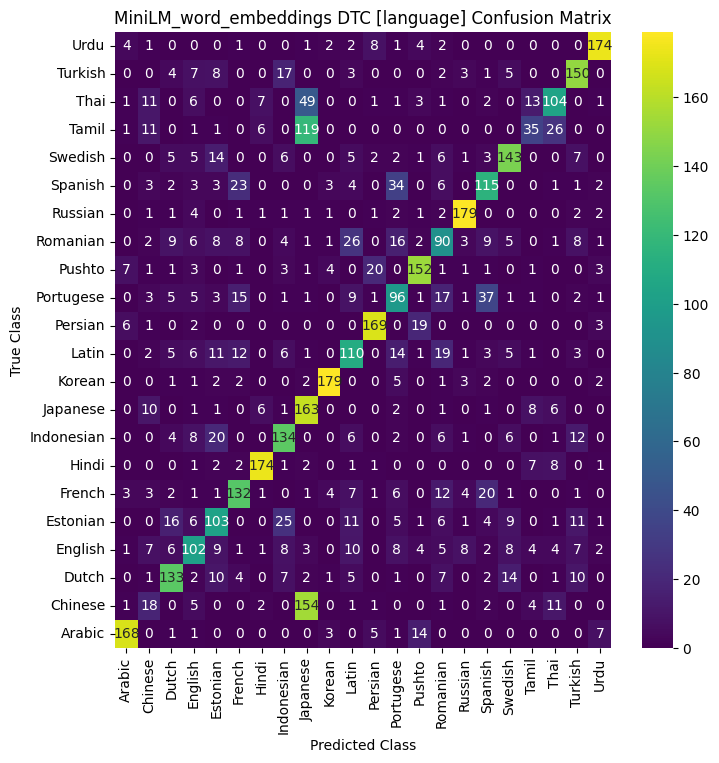

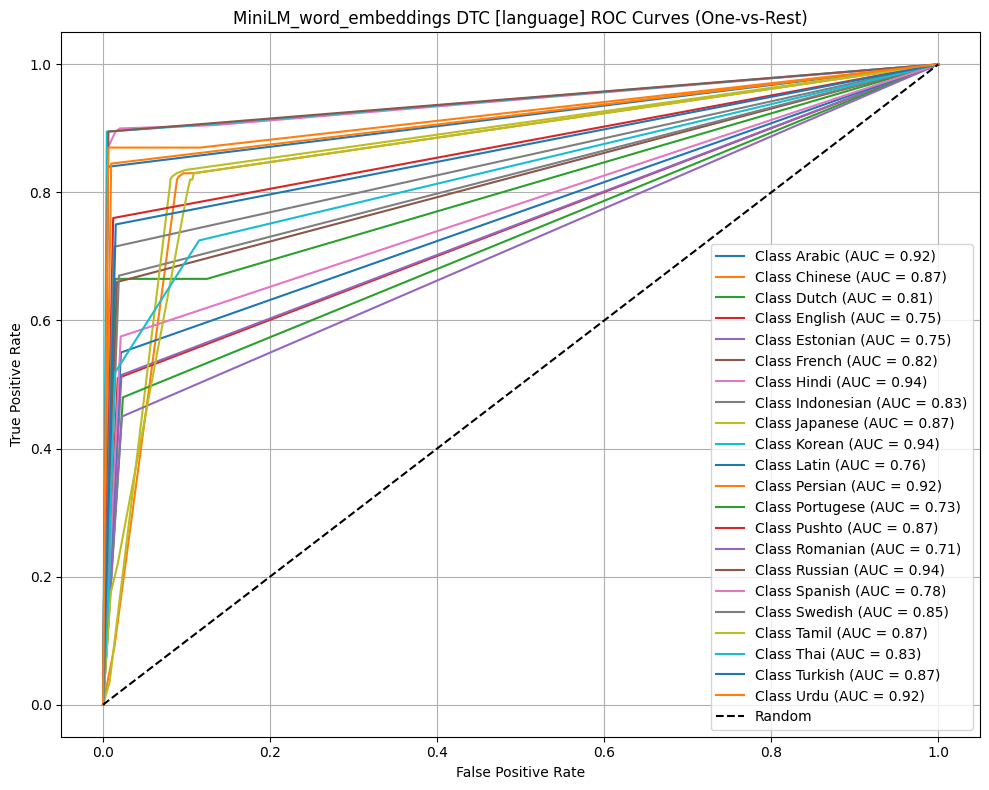

In [37]:
model= train_single_ml_model(
    Algorithm_prefix="MiniLM_word_embeddings",
    features=features,        # features for the target
    y_encoded=Y_dict["language"],  # labels for the target
    target_name="language",
    algorithm="DTC"
)

Loading existing KNN model for language...
MiniLM_word_embeddings KNN [language] Accuracy  : 80.68
MiniLM_word_embeddings KNN [language] Precision : 85.68
MiniLM_word_embeddings KNN [language] Recall    : 80.68
MiniLM_word_embeddings KNN [language] FScore    : 78.97
MiniLM_word_embeddings KNN [language] Classification Report
MiniLM_word_embeddings KNN [language]
              precision    recall  f1-score   support

      Arabic       0.95      0.99      0.97       200
     Chinese       0.34      0.88      0.49       200
       Dutch       0.85      0.96      0.91       200
     English       0.81      0.63      0.71       200
    Estonian       0.72      0.93      0.81       200
      French       0.88      0.94      0.91       200
       Hindi       0.93      0.90      0.92       200
  Indonesian       0.72      0.93      0.81       200
    Japanese       1.00      0.04      0.09       200
      Korean       0.99      0.99      0.99       200
       Latin       0.76      0.88      0

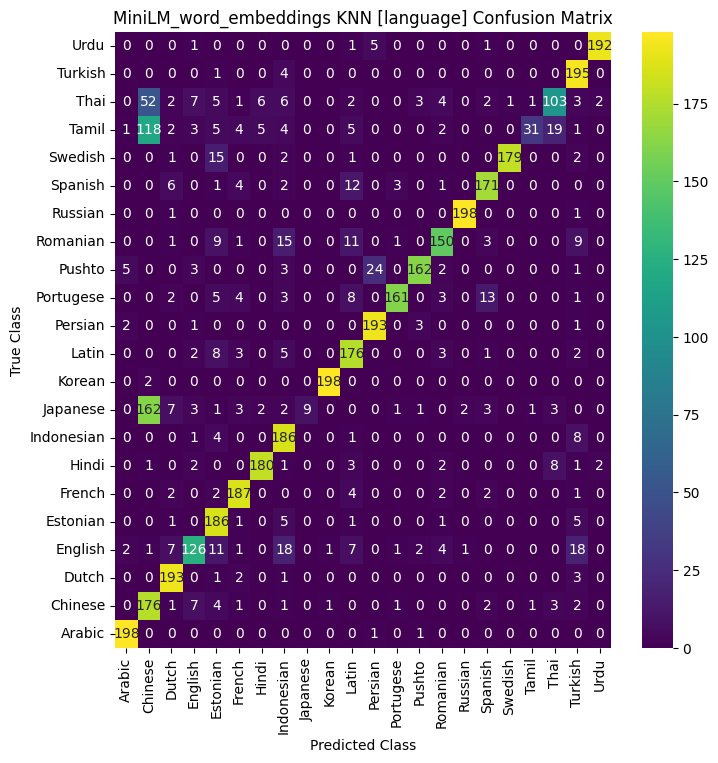

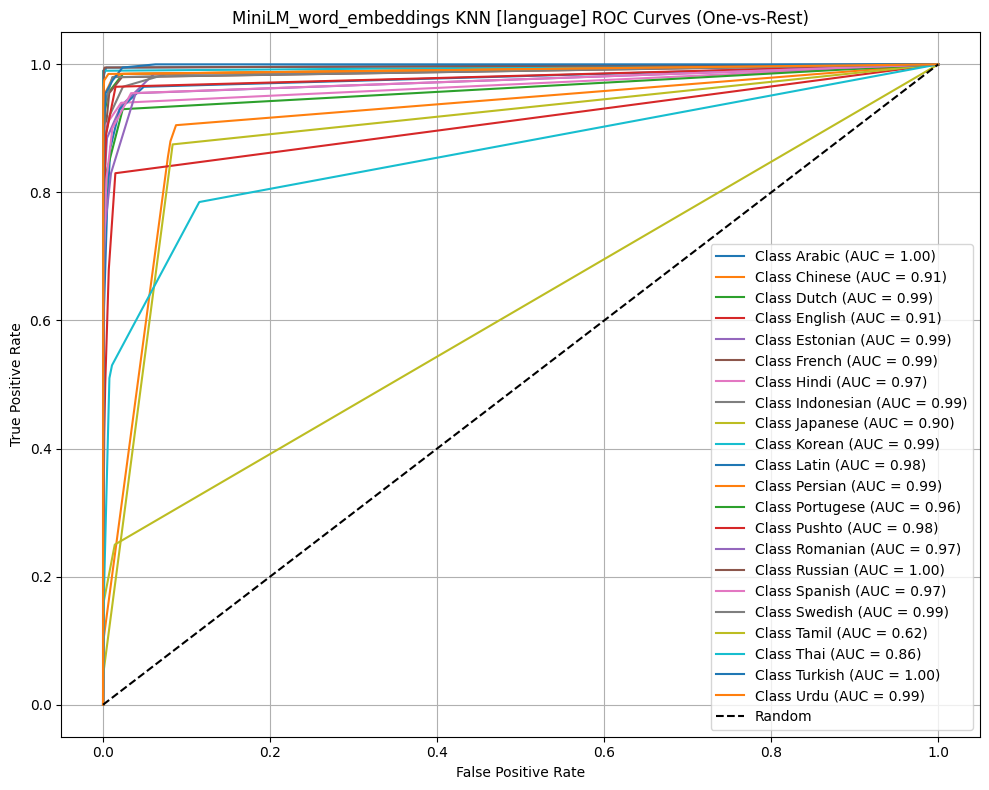

In [38]:
model = train_single_ml_model(
    Algorithm_prefix="MiniLM_word_embeddings",
    features=features,        # features for the target
    y_encoded=Y_dict["language"],  # labels for the target
    target_name="language",
    algorithm="KNN"
)

Loading existing NBC model for language...
MiniLM_word_embeddings NBC [language] Accuracy  : 72.86
MiniLM_word_embeddings NBC [language] Precision : 73.57
MiniLM_word_embeddings NBC [language] Recall    : 72.86
MiniLM_word_embeddings NBC [language] FScore    : 71.43
MiniLM_word_embeddings NBC [language] Classification Report
MiniLM_word_embeddings NBC [language]
              precision    recall  f1-score   support

      Arabic       0.95      0.78      0.85       200
     Chinese       0.00      0.00      0.00       200
       Dutch       0.91      0.93      0.92       200
     English       0.53      0.89      0.66       200
    Estonian       0.78      0.87      0.82       200
      French       0.91      0.88      0.89       200
       Hindi       0.92      0.82      0.87       200
  Indonesian       0.63      0.82      0.72       200
    Japanese       0.34      0.78      0.47       200
      Korean       1.00      0.90      0.94       200
       Latin       0.70      0.79      0

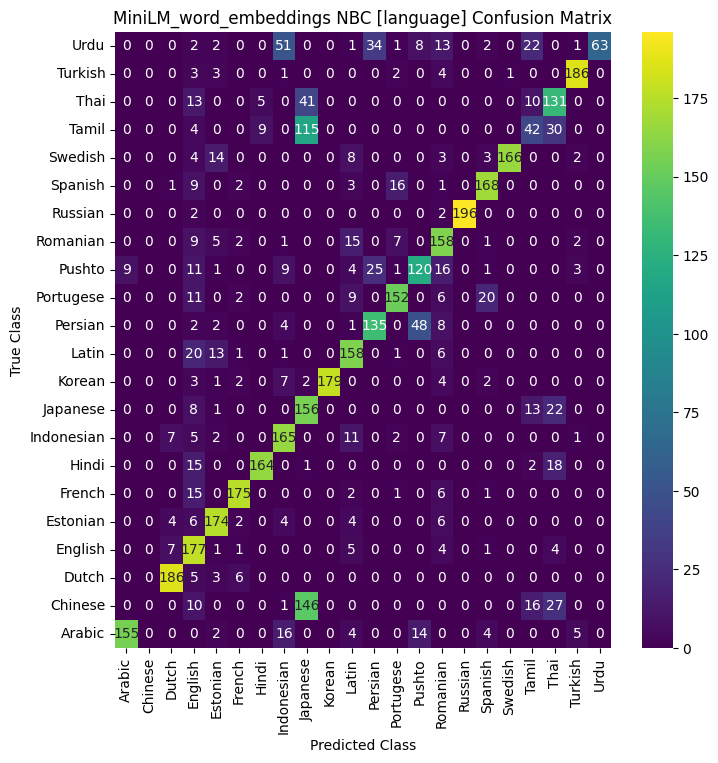

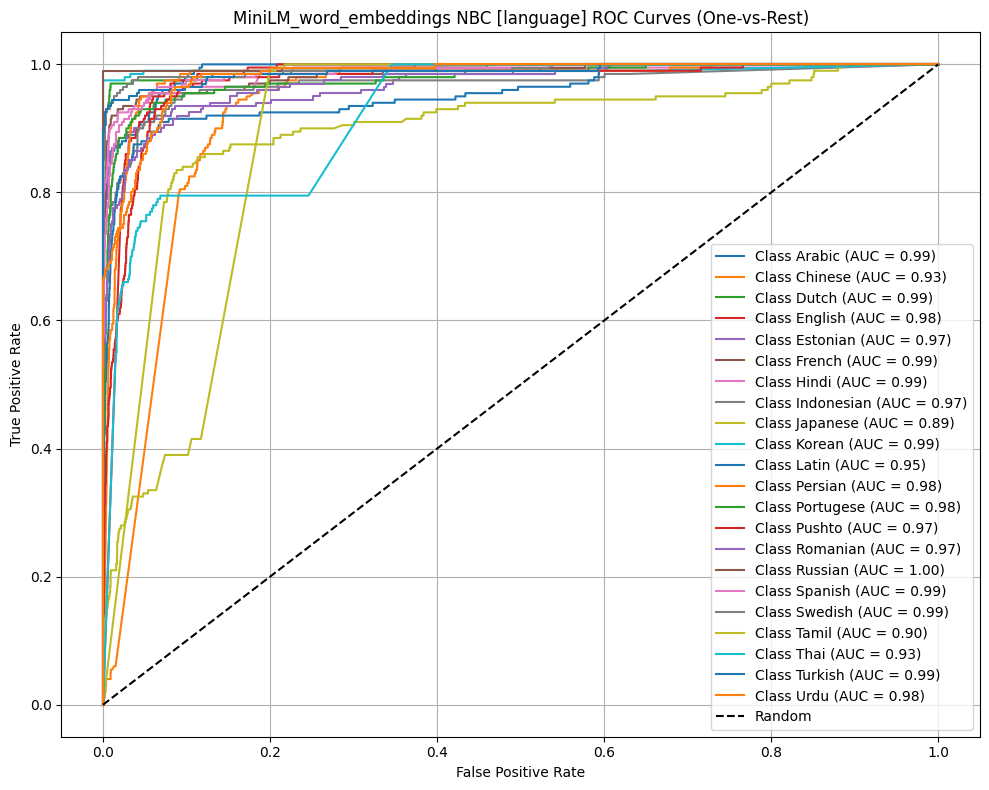

In [39]:
model = train_single_ml_model(
    Algorithm_prefix="MiniLM_word_embeddings",
    features=features,        # features for the target
    y_encoded=Y_dict["language"],  # labels for the target
    target_name="language",
    algorithm="NBC"
)

Loading existing RFC model for language...
MiniLM_word_embeddings RFC [language] Accuracy  : 99.00
MiniLM_word_embeddings RFC [language] Precision : 99.00
MiniLM_word_embeddings RFC [language] Recall    : 99.00
MiniLM_word_embeddings RFC [language] FScore    : 99.00
MiniLM_word_embeddings RFC [language] Classification Report
MiniLM_word_embeddings RFC [language]
              precision    recall  f1-score   support

      Arabic       0.99      0.98      0.99       200
     Chinese       0.99      0.98      0.99       200
       Dutch       0.98      0.98      0.98       200
     English       0.99      0.99      0.99       200
    Estonian       0.99      0.99      0.99       200
      French       0.98      0.99      0.99       200
       Hindi       0.99      0.99      0.99       200
  Indonesian       0.99      0.98      0.99       200
    Japanese       0.99      1.00      1.00       200
      Korean       0.99      0.98      0.99       200
       Latin       0.99      0.98      0

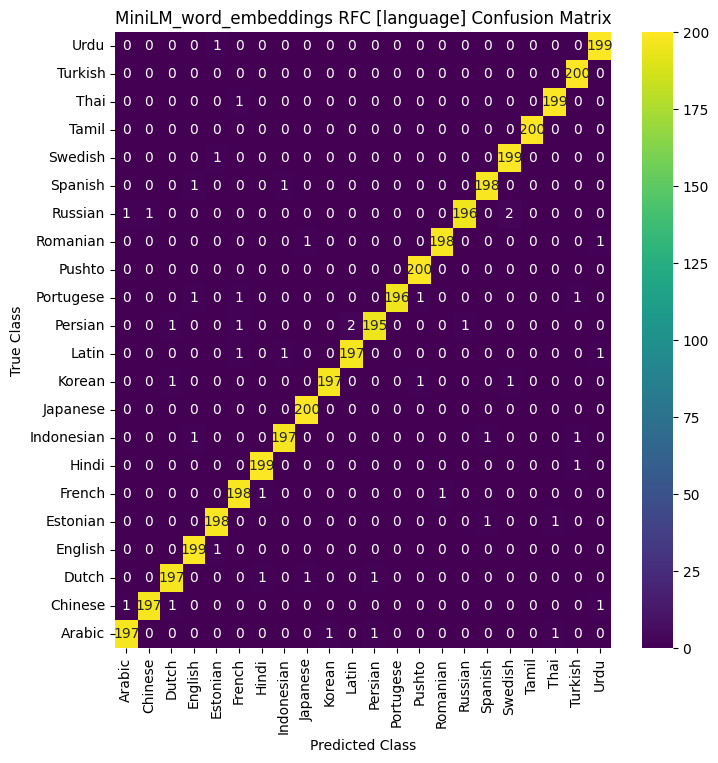

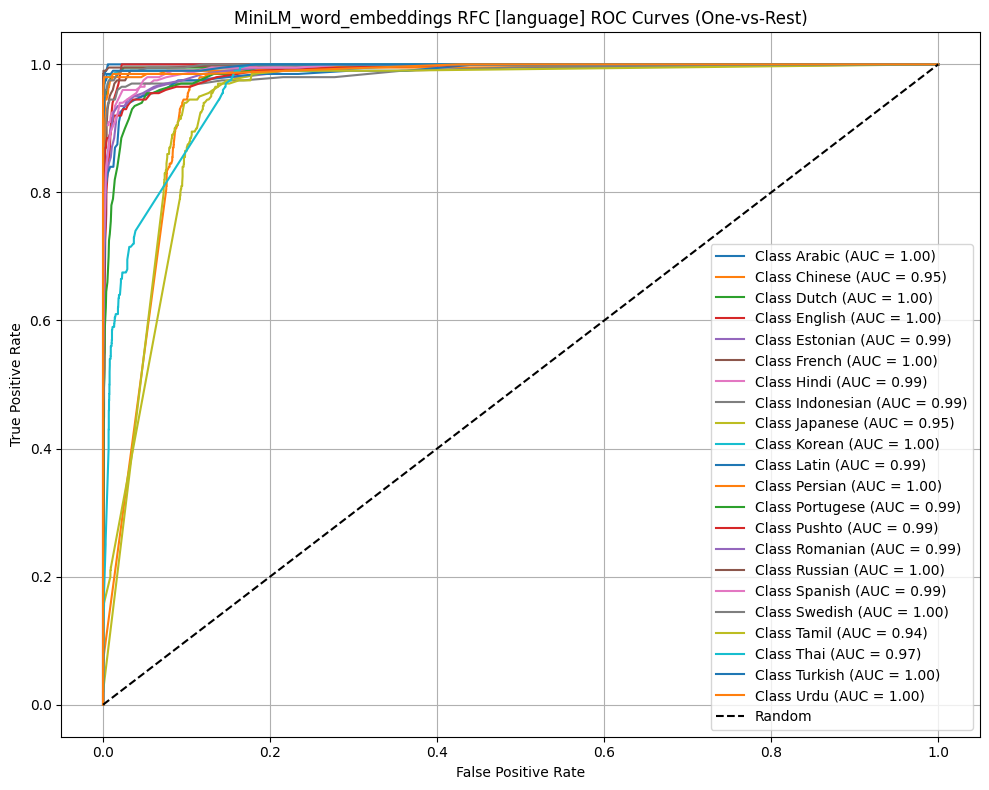

In [40]:
model = train_single_ml_model(
    Algorithm_prefix="MiniLM_word_embeddings",
    features=features,        # features for the target
    y_encoded=Y_dict["language"],  # labels for the target
    target_name="language",
    algorithm="RFC"
)

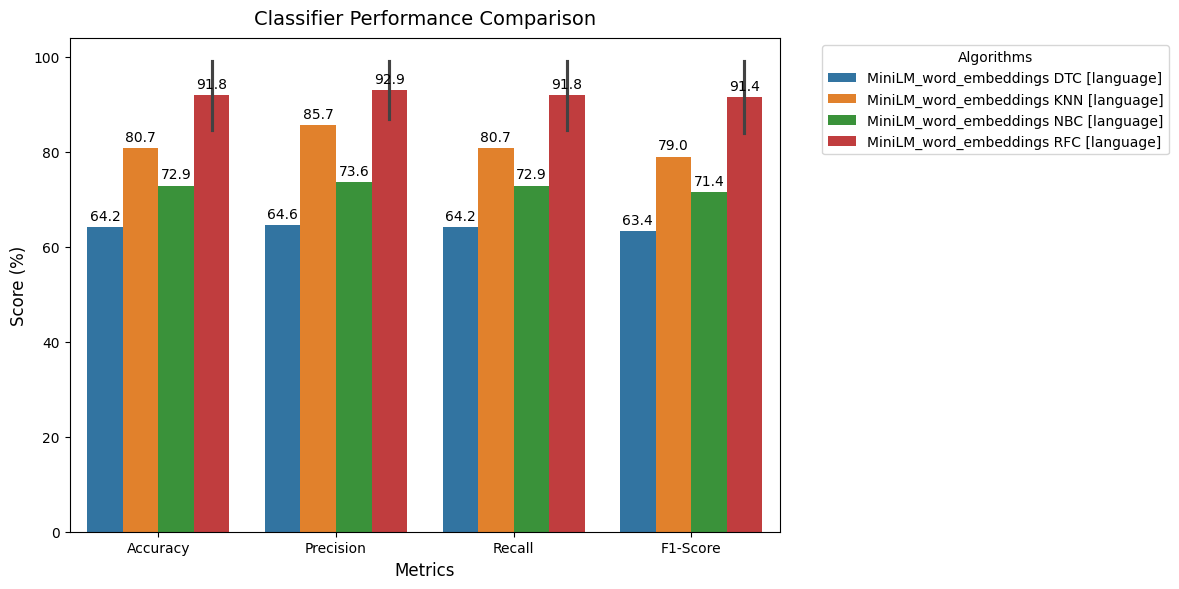

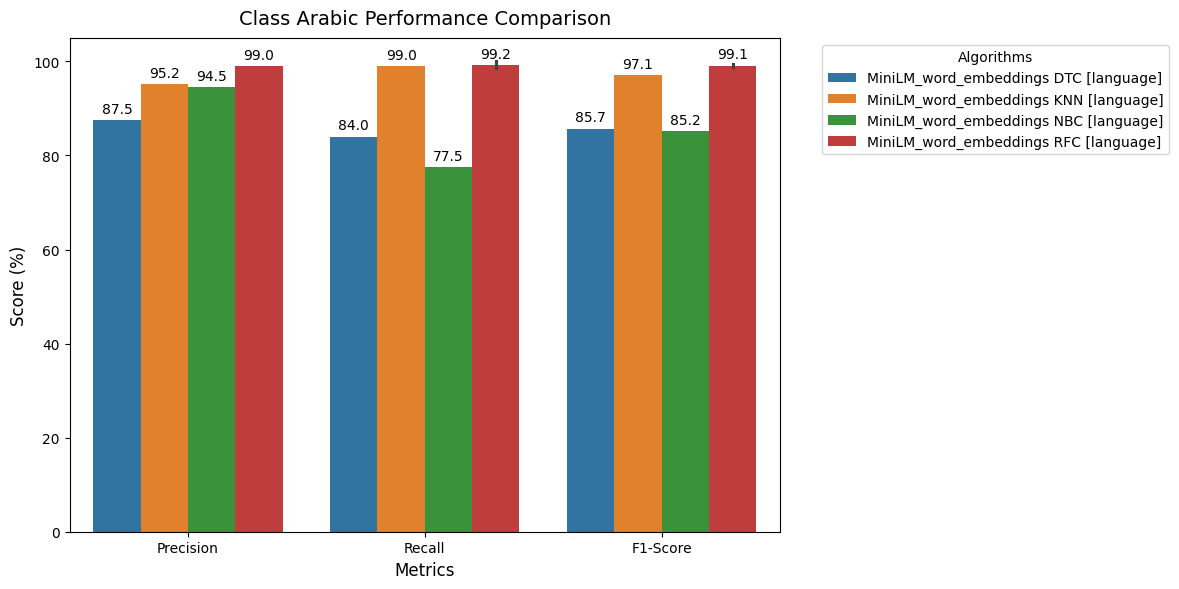

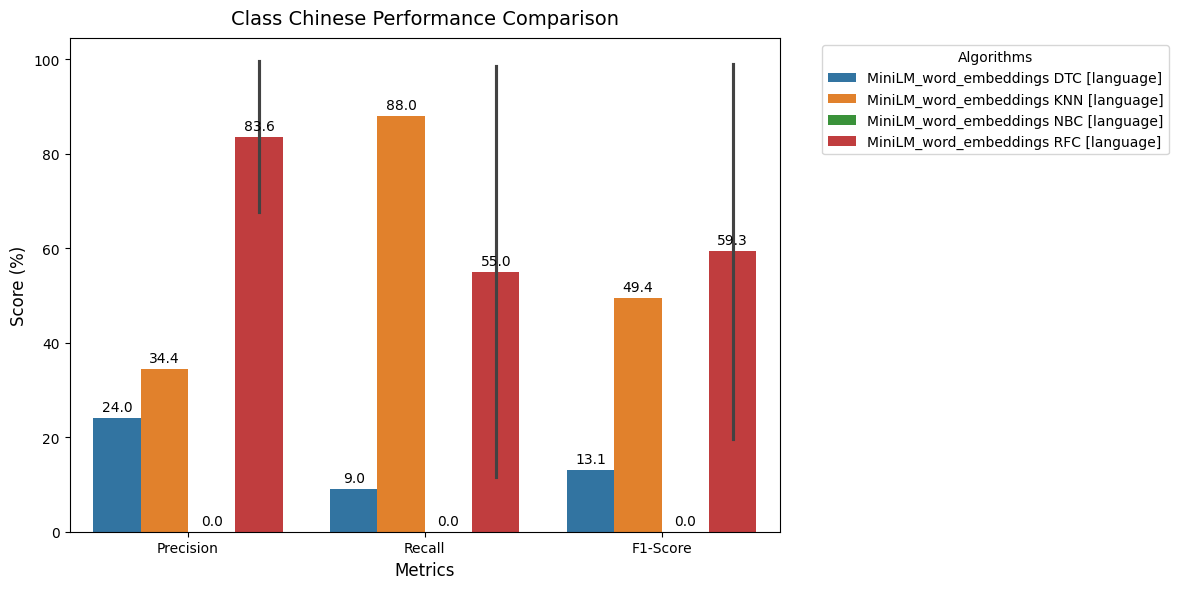

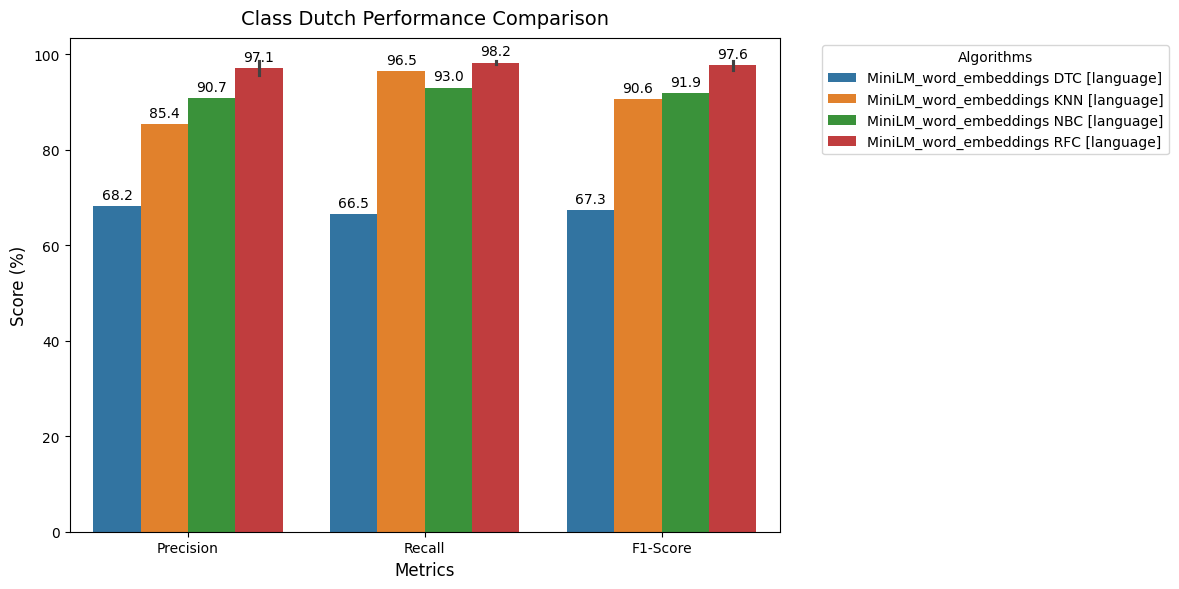

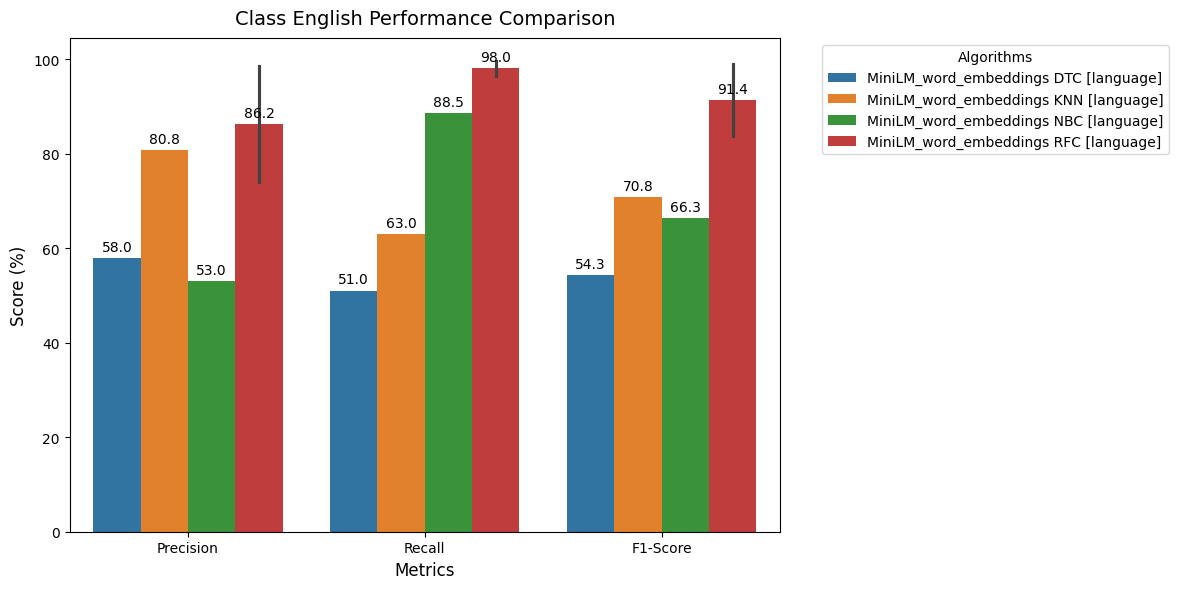

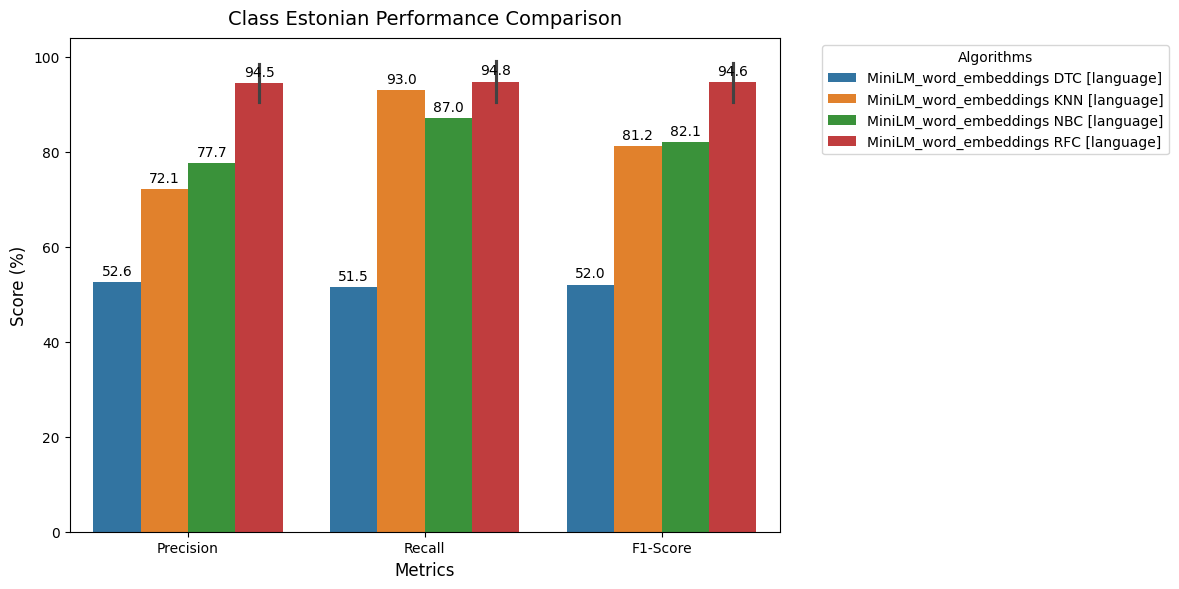

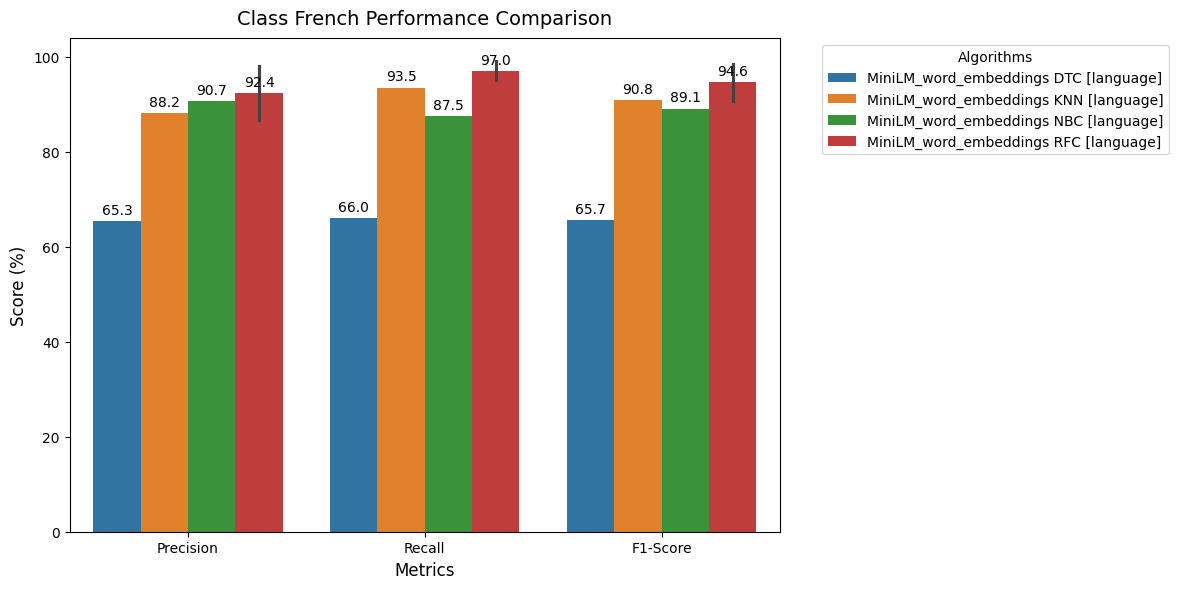

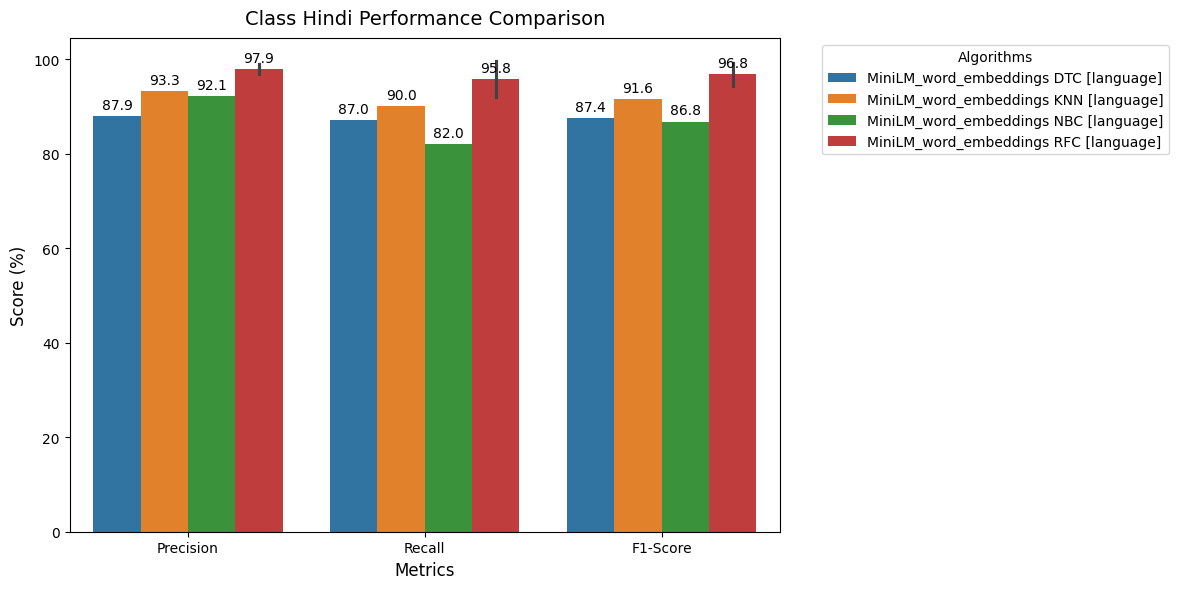

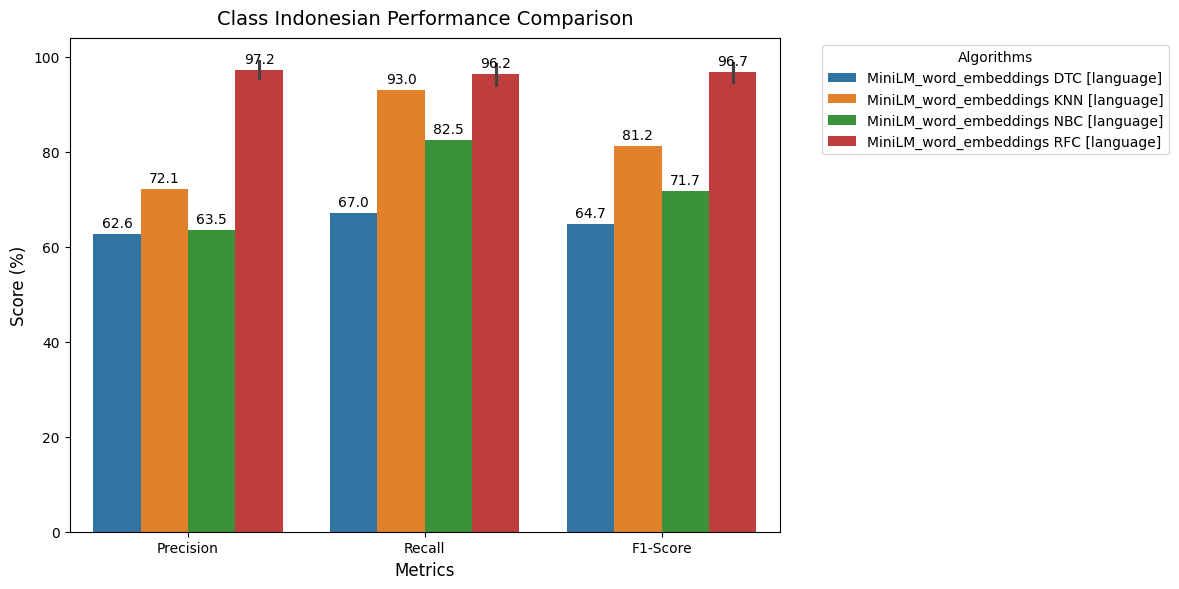

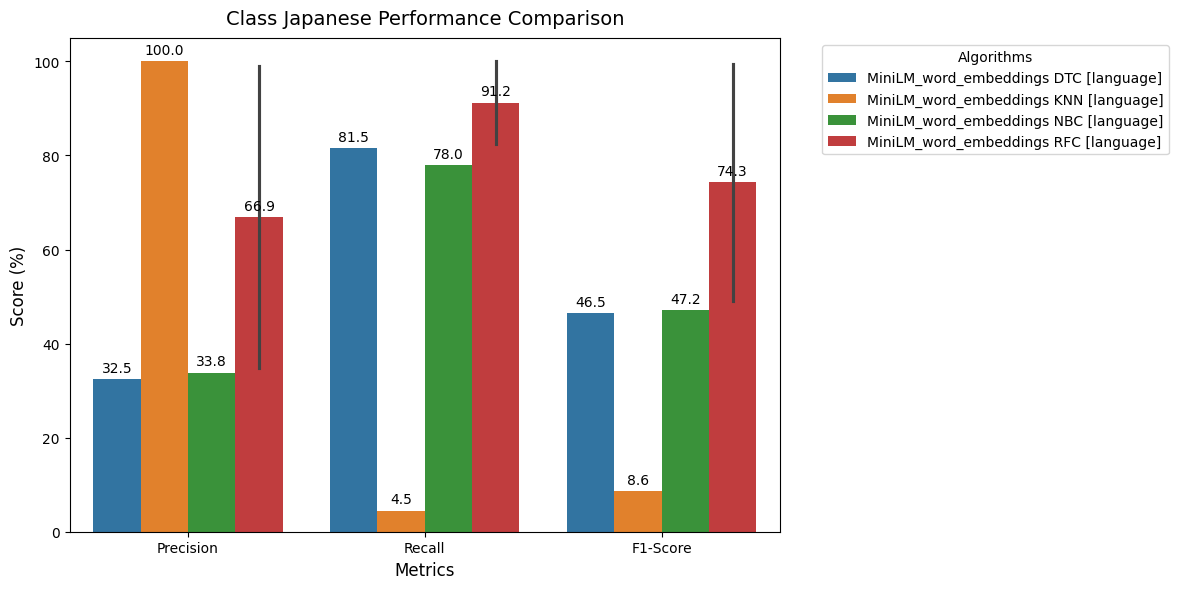

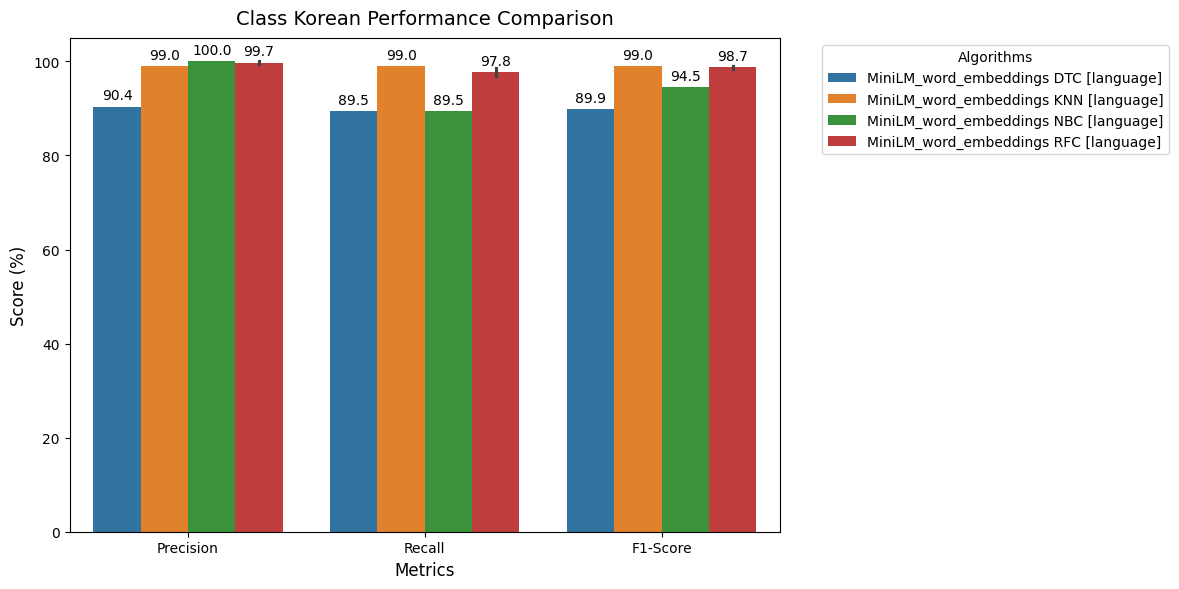

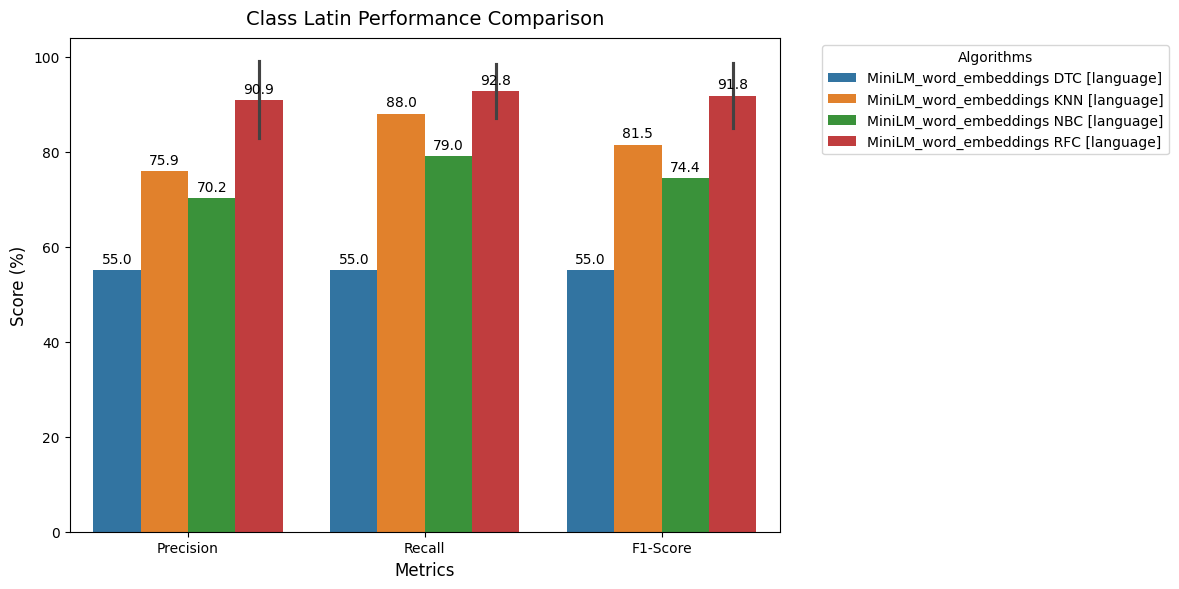

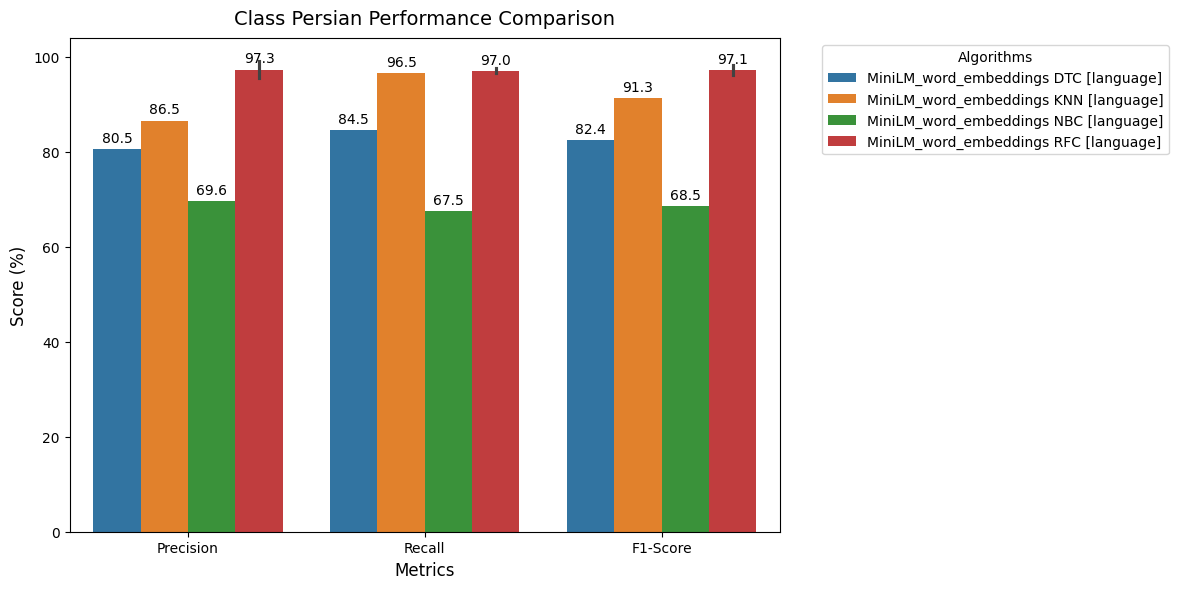

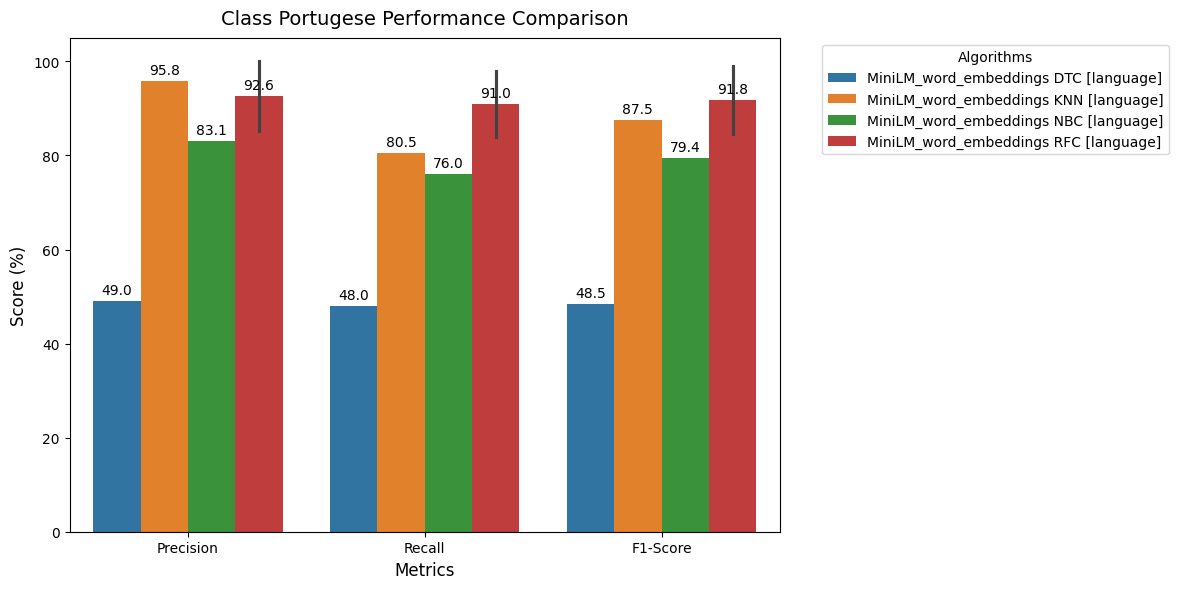

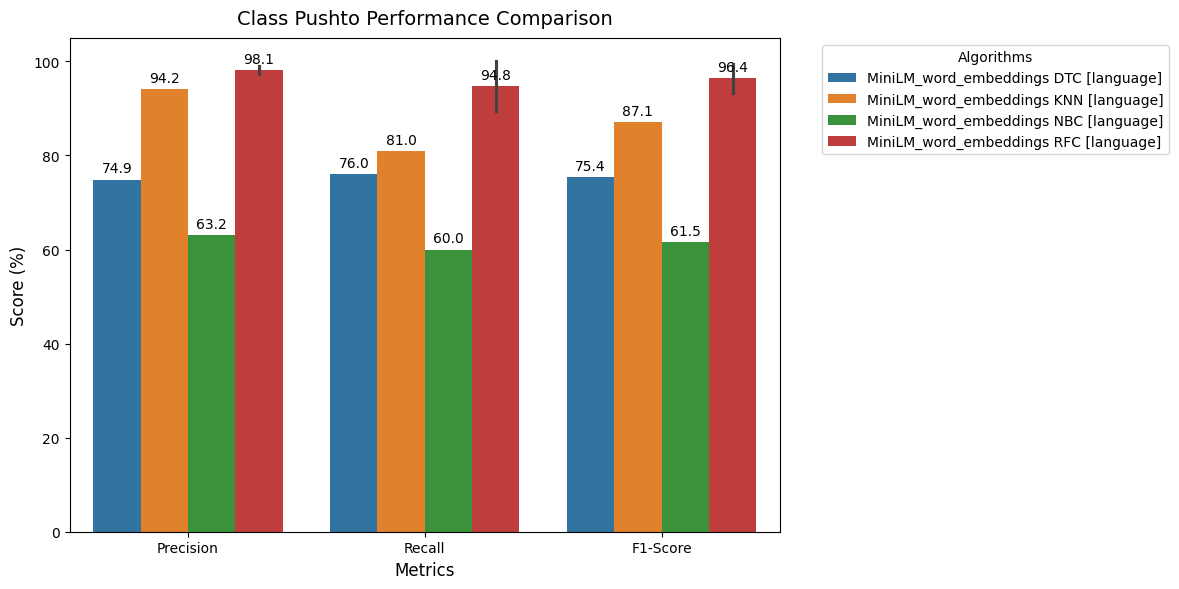

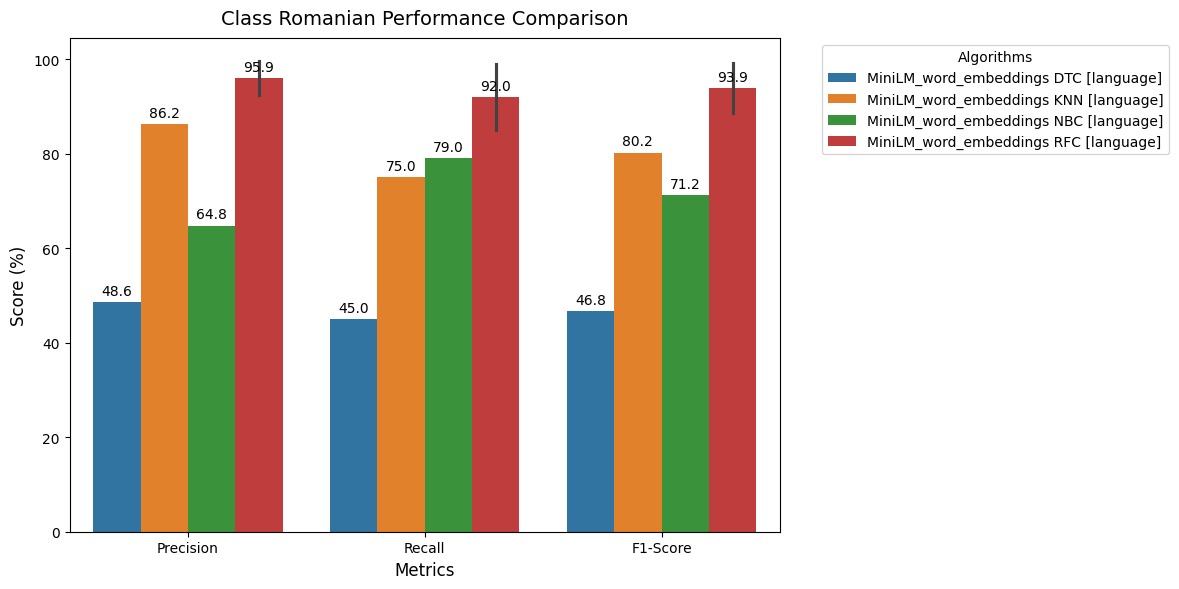

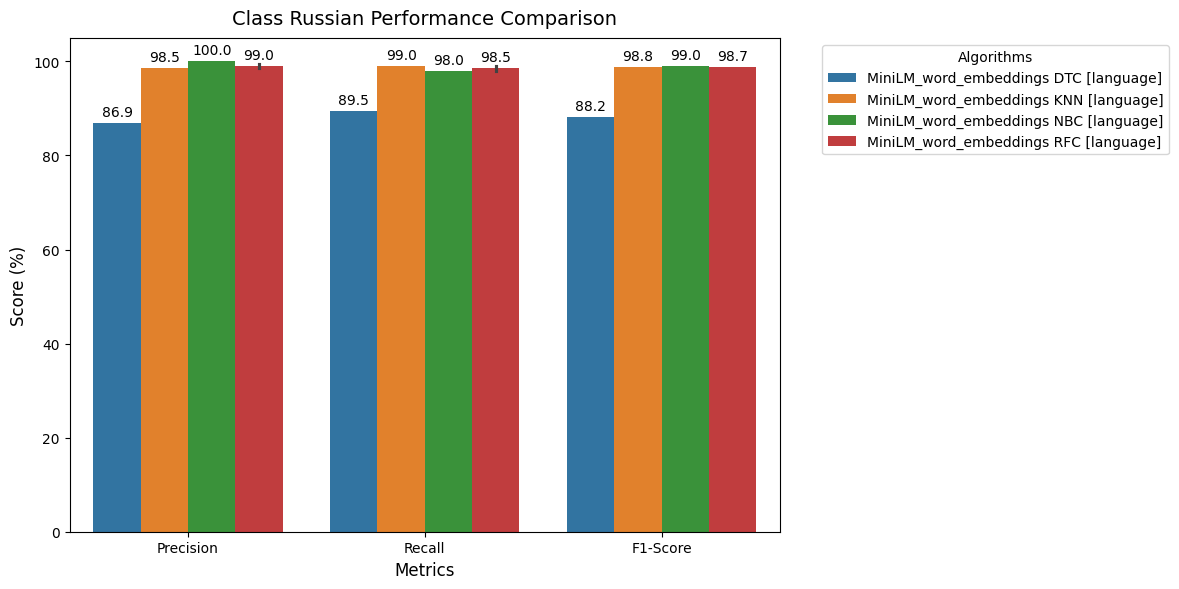

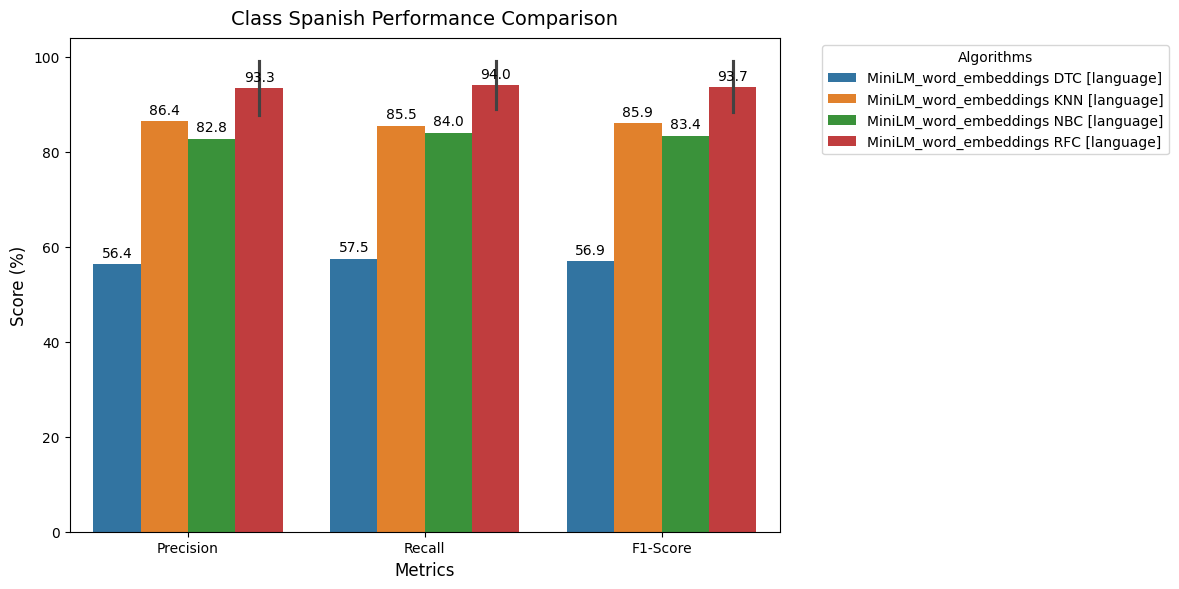

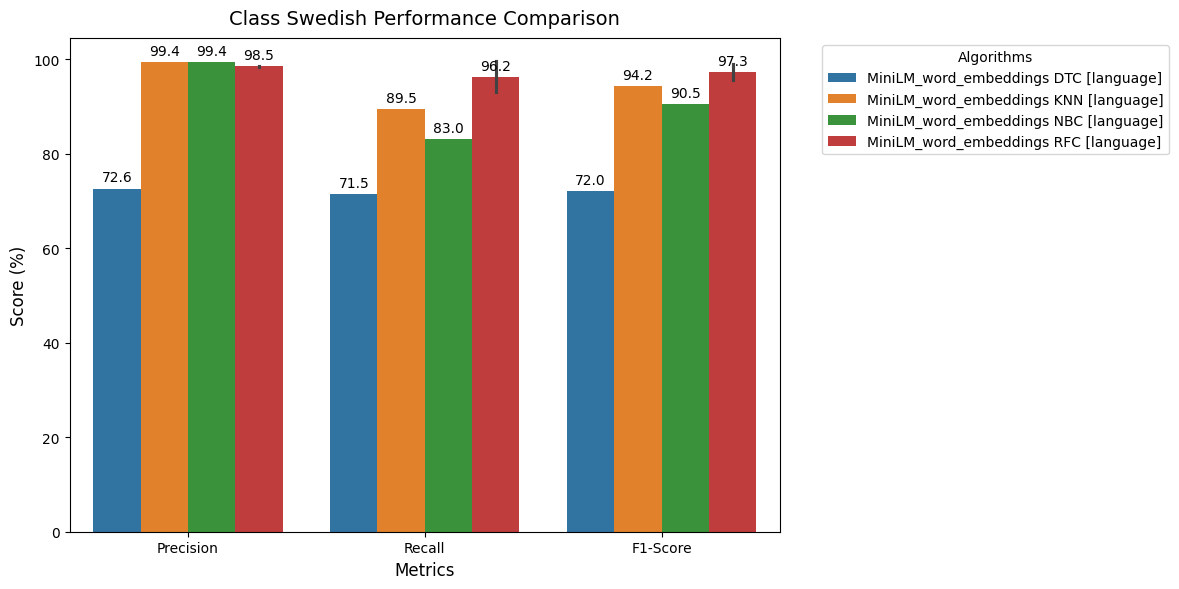

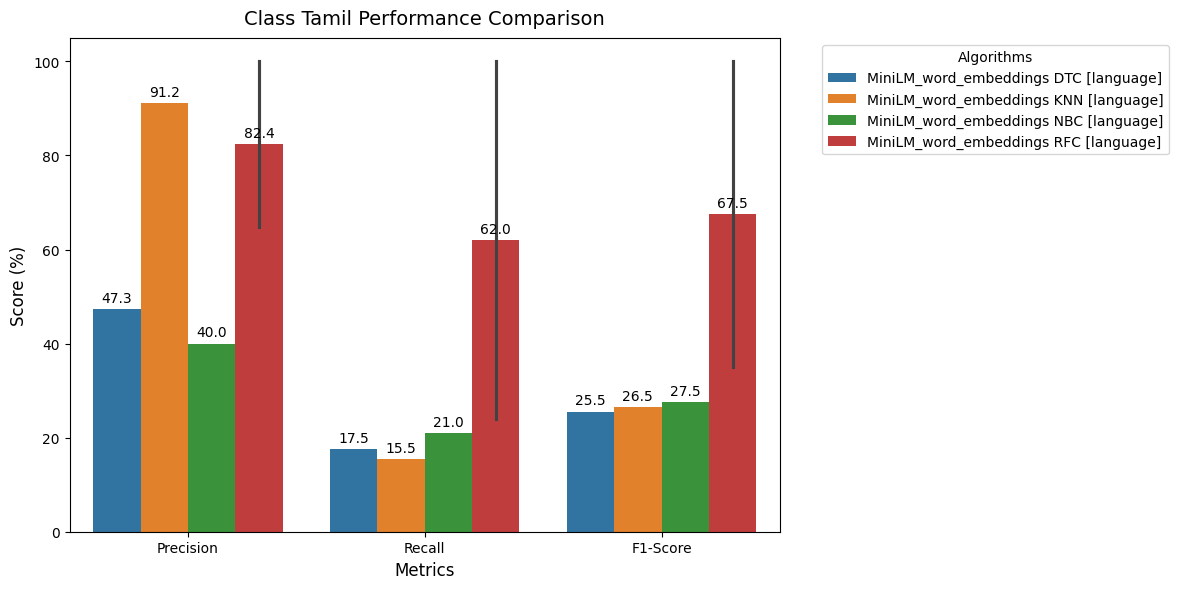

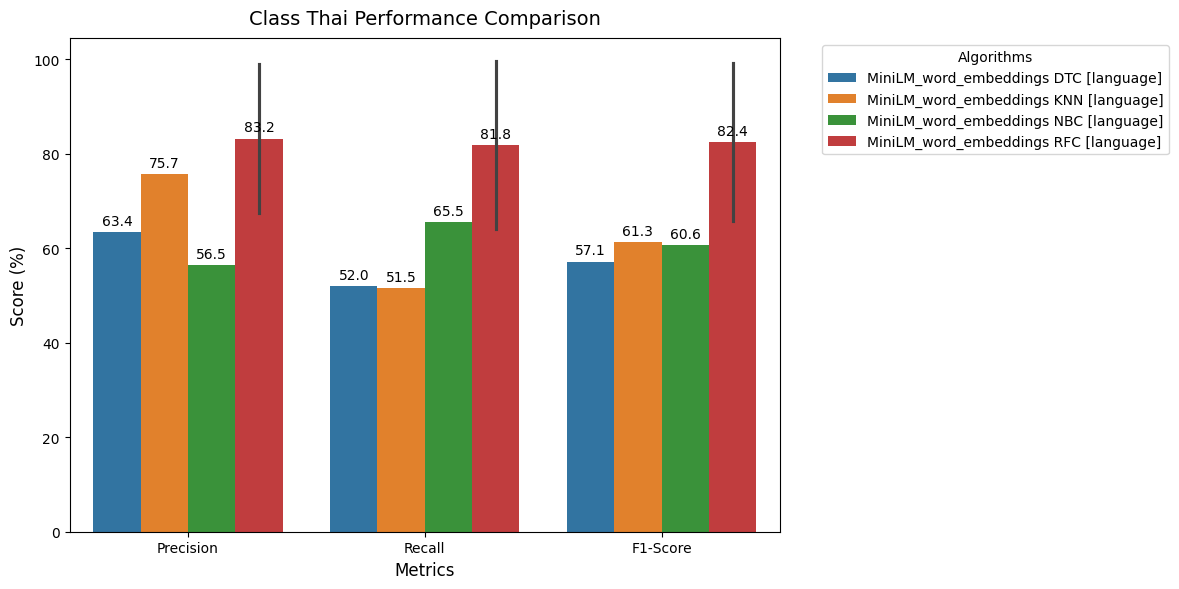

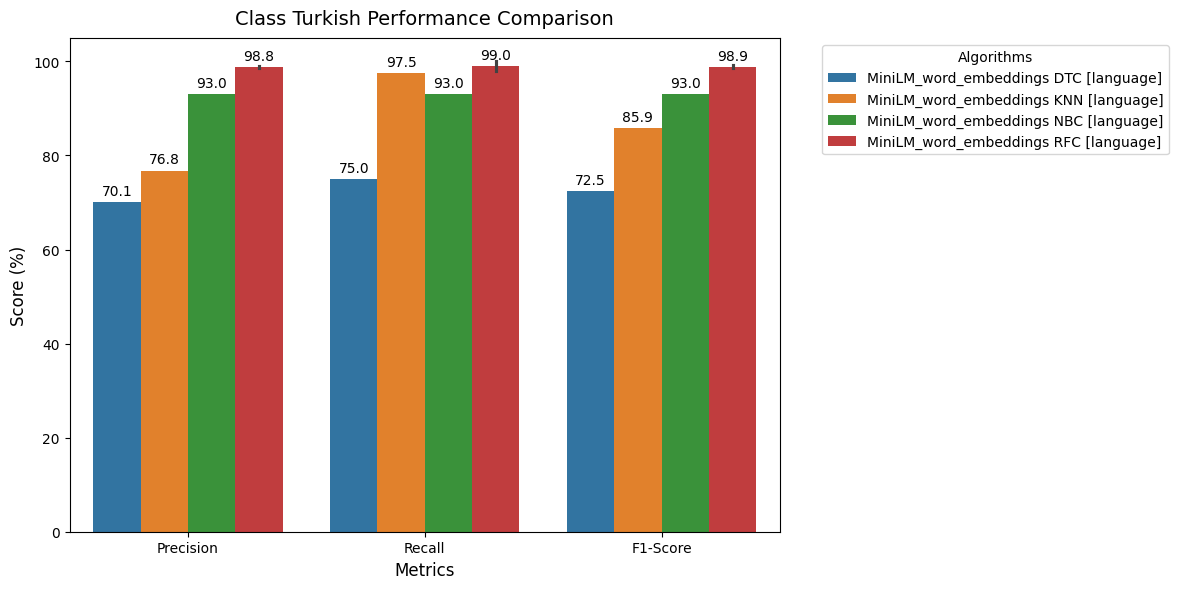

In [ ]:
graph_plotter_lb1 = GraphPlotter(metrics_calculator_lb1.metrics_df, metrics_calculator_lb1.class_performance_dfs)
graph_plotter_lb1.plot_all()

In [ ]:
# Work-Life Balance
melted_df_lb1 = metrics_calculator_lb1.metrics_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].copy()
melted_df_lb1 = melted_df_lb1.round(3)
melted_df_lb1